There might be cases where you are interested to see how closely your numeric data follows some hypothetical distribution. This might be important for certain parametric statistical tests, like checking for assumptions of normality. In cases like this, you can use a quantile-quantile plot, or **Q-Q plot**, to make a visual comparison between your data and your reference distribution. Take for example the following comparison of the following data and a hypothetical normal distribution using the sample statistics:

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [ ]:
# create a histogram of the data
bin_size = 0.5
bin_edges = np.arange(4, 18 + bin_size, bin_size)
plt.hist(data = df, x = 'num_var', bins = bin_edges);

# overlay a theoretical normal distribution on top
samp_mean = df['num_var'].mean()
samp_sd = df['num_var'].std()

from scipy.stats import norm
x = np.linspace(4, 18, 200)
y = norm.pdf(x, samp_mean, samp_sd) # normal distribution heights
y *= df.shape[0] * bin_size # scale the distribution height

plt.plot(x, y)

The matplotlib [`plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) function is a generic function for plotting y-values against x-values, by default a line connecting each x-y pair in sequence. In this case, I first use numpy's [`linspace`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.linspace.html) function to generate x-values across the range of the plot. Note that the first two arguments match the `bin_edges` limits, while the third argument specifies the number of values to generate between the two endpoints. Then, I use the scipy package's [`norm`](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.norm.html) class to get the height of the normal distribution curve at those x-values, using the sample mean and standard deviation as distribution parameters. `pdf` stands for probability density function, which returns the normal distribution height (density) at each value of x. These values are such that the total area under the curve will add up to 1. Since we've got a histogram with absolute counts on the y-axis, we need to scale the curve so it's on the same scale as the main plot: we do this by multiplying the curve heights by the number of data points and bin size. The code above gives us the following plot:

<img src="assets/qqplot.png" width=400px>

From a visual inspection of this overlaid plot, it looks like the data is a bit sparse on the right side compared to the expected normal distribution. There's also a bit of a spike of values between 11 and 12. On the other hand, the left side of the curve isn't too far off from the expected distribution, though it might be said that we might be missing some expected points in the left tail of the distribution. The question that we'd like to address is if there's enough evidence from what we've observed to say that the data is significantly different from the expected normal distribution.

One way we could approach this is through a statistical test, such as using scipy's [`shapiro`](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.shapiro.html) function to perform the Shapiro-Wilk test. But since this is a course on data visualization, we'll inspect this question visually, using the Q-Q plot type teased at the top of the page. The main idea of the plot is this: if the data was normally distributed, then we'd expect a certain pattern in terms of how far each data point is from the mean of the distribution. If we order the points from smallest to largest, then we could compare how large the _k_-th ranked data point is against the _k_-th ranked point from the expected distribution.

To get these expected values, we'll make use of the `norm` class's `ppf` function, which stands for percent point function. The ppf takes as input a proportion (valued between 0 and 1) and returns the value in the distribution that would leave that proportion of the curve to the left. For a standard normal distribution (mean = 0, standard deviation = 1), the $ppf$(0.25) = -0.674, $ppf$(0.5) = 0 and $ppf$(0.75) = 0.674. The main question, then, is what values to stick into the *ppf*.

There's a few different conventions around this, but they generally take the form of the following equation:

> Given _n_ data points, the _k_-th value should be at probability point $\frac{k-a}{n+1-2a}$, for some _a_ between 0 and 1 (inclusive).

This equation distributes the probability points symmetrically about 0.5, and adjusting _a_ changes how much probability is left in the tails of the [0,1] range. Commonly, _a_ is set to a balanced value of 0.5, which gives the equation $\frac{k-0.5}{n}$. Let's put this all together using code:

In [ ]:
n_points = df.shape[0]
qs = (np.arange(n_points) - .5) / n_points
expected_vals = norm.ppf(qs, samp_mean, samp_sd)

plt.scatter(expected_vals, df['num_var'].sort_values())
plt.plot([4, 18], [4, 18], '--', color='black')
plt.axis('equal')
plt.xlabel('Expected Values')
plt.ylabel('Observed Values')

It's a good idea to label the axes in this case. Since the actual and expected data are both on the same scale, the labels are a big help to keep things clear. In addition, rather than just plotting the expected and actual data alone, I've also added another `plot` call to add a diagonal x = y line. If the data matches the actual values perfectly on the expected value, they will fall directly on that diagonal line. The `plt.axis('equal')` line supports the visualization, as it will set the axis scaling to be equal, and the diagonal line will be at a 45 degree angle.

<img src="assets/qqplot2.png" width=400px>

Excepting the smallest and largest few points, the distribution of observed values is actually fairly in line with the distribution of expected values – that is, it falls along the diagonal line. The smallest and largest observed points are larger than the values that would be expected from the normal distribution, but it's not by much. Given how much farther values can get spread out in the tails of the normal distribution, this shouldn't be a major concern. We're probably fine in treating the data as normally distributed.

Usually, the Q-Q plot is computed and rendered in terms of standardized units, rather than the scale of the original data. A standardized dataset has a mean of 0 and standard deviation of 1, so to convert a set of values into standard scores, we just need to subtract the sample mean from each value to center it around 0, then divide by the sample standard deviation to scale it. Calling methods of the `norm` class without arguments for the mean or standard deviation assume the standard normal distribution. The code changes as follows:

In [ ]:
expected_scores = norm.ppf(qs)
data_scores = (df['num_var'].sort_values() - samp_mean) / samp_sd

plt.scatter(expected_scores, data_scores)
plt.plot([-2.5, 3], [-2.5, 3], '--', color='black')
plt.axis('equal')
plt.xlabel('Expected Standard Scores')
plt.ylabel('Observed Standard Scores')

<img src="assets/qqplot3.png" width=400px>

Notice that the shape of the data has not changed since both datasets have been scaled in the exact same way. One of the reasons for performing this scaling is that it makes it easier to talk about the data values against the expected, theoretical distribution. In the first plot, there's no clear indication of where the center of the data lies, and how spread out the data is from that center. In the latter plot, we can use our expectations for how much of the data should be one or two standard deviations from the mean to better understand how the data is distributed. It also separates the values of the theoretical distribution from any properties of the observed data.

Before closing this page out, let's take a quick look at the Q-Q plot when the data distribution does not fit the normal distribution assumptions. Instead of generating data from a normal distribution, I'll now generate data from a uniform distribution:

Text(0, 0.5, 'Observed Standard Scores')

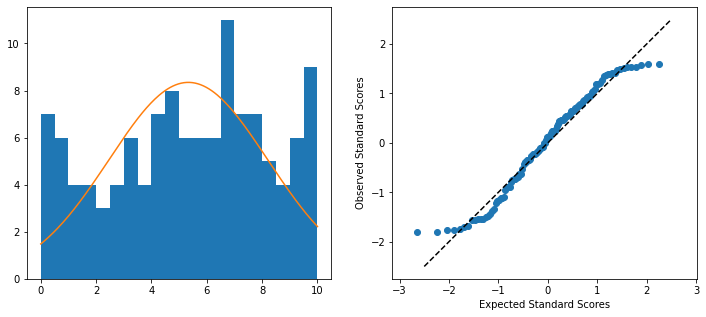

In [3]:
# generate the data
from scipy.stats import norm
np.random.seed(8322489)

n_points = 120
unif_data = np.random.uniform(0, 10, n_points)

# set up the figure
plt.figure(figsize=[12, 5])

# left subplot: plot the data
plt.subplot(1, 2, 1)
bin_size = 0.5
bin_edges = np.arange(0, 10 + bin_size, bin_size)
plt.hist(x=unif_data, bins=bin_edges);

# overlay a theoretical normal distribution on top
samp_mean = unif_data.mean()
samp_sd = unif_data.std()

x = np.linspace(0, 10, 200)
y = norm.pdf(x, samp_mean, samp_sd)  # normal distribution heights
y *= n_points * bin_size  # scale the distribution height
plt.plot(x, y)

# right subplot: create a Q-Q plot
plt.subplot(1, 2, 2)

qs = (np.arange(n_points) - .5) / n_points
expected_scores = norm.ppf(qs)
data_scores = (np.sort(unif_data) - samp_mean) / samp_sd

plt.scatter(expected_scores, data_scores)
plt.plot([-2.5, 2.5], [-2.5, 2.5], '--', color='black')
plt.axis('equal')
plt.xlabel('Expected Standard Scores')
plt.ylabel('Observed Standard Scores')

When we compare the random standardized scores drawn from the uniform distribution to the expected scores from the theoretical normal distribution in the Q-Q plot, we see an S-shaped curve. The comparison of values in the middle of the curve are approximately linear in trend, but the slope is steeper than the desired y = x. Meanwhile on the edges, the slope is extremely shallow, as the uniform distribution is fixed to a finite range, but the normal distribution values in the tails are expected to be much further away. You can somewhat see this in the superimposed distribution line in the left-side plot, where even at the edges of the data, there is still quite a bit of height to the theoretical normal curve. All of this contributes to the result that the randomly-generated uniform data can't be well-approximated by the normal distribution.